In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01f0)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001f0,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

┌ Warning: No functional GPU backend found! Defaulting to CPU.
│ 
│ 1. If no GPU is available, nothing needs to be done. Set `MLDATADEVICES_SILENCE_WARN_NO_GPU=1` to silence this warning.
│ 2. If GPU is available, load the corresponding trigger package.
│     a. `CUDA.jl` and `cuDNN.jl` (or just `LuxCUDA.jl`) for  NVIDIA CUDA Support.
│     b. `AMDGPU.jl` for AMD GPU ROCM Support.
│     c. `Metal.jl` for Apple Metal GPU Support. (Experimental)
│     d. `oneAPI.jl` for Intel oneAPI GPU Support. (Experimental)
└ @ MLDataDevices.Internal ~/.julia/packages/MLDataDevices/pxlxr/src/internal.jl:112


(::CPUDevice{Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 10, use_cuda = true)

Args(0.0003, 128, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

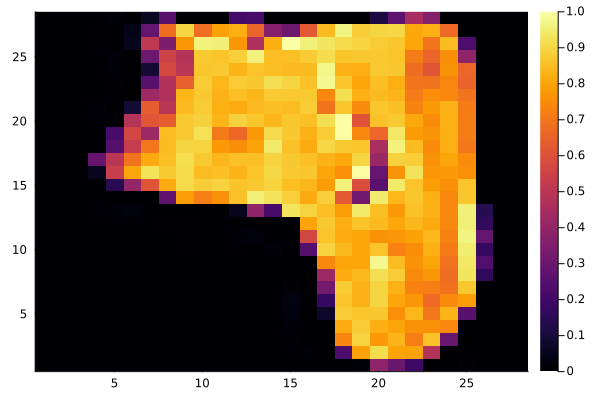

In [15]:
heatmap(x0[:,:,1])

# Test conventional network

In [16]:
model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            Conv((16, 16), 1 => 3, relu),
            Conv((8, 8), 3 => 1, relu),
            FlattenLayer(),
            Dense(36 => 128, relu),
            Dense(128 => 10),
            softmax)

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#31),
    layer_3 = Conv((16, 16), 1 => 3, relu),       # 771 parameters
    layer_4 = Conv((8, 8), 3 => 1, relu),         # 193 parameters
    layer_5 = FlattenLayer{Nothing}(nothing),
    layer_6 = Dense(36 => 128, relu),             # 4_736 parameters
    layer_7 = Dense(128 => 10),                   # 1_290 parameters
    layer_8 = WrappedFunction(softmax),
)         # Total: 8_558 parameters,
          #        plus 0 states.

In [17]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.019709477 0.0077816104 … 0.05482017 -0.08519609; -0.14134635 0.20817417 … 0.09868311 0.17127244; … ; -0.12946782 0.023861565 … -0.13425288 -0.19576402; 0.13110001 0.05310778 … 0.065689325 -0.13362738;;;; 0.15503614 -0.17867574 … -0.15539703 0.05237471; -0.045117833 -0.033451576 … -0.10569792 0.05006388; … ; 0.20915674 0.10383065 … -0.19610864 -0.039417222; 0.0066004097 0.08147644 … -0.11394326 -0.18828012;;;; -0.178612 0.08852646 … -0.07514592 0.18356745; -0.19098079 -0.19624312 … 0.21617825 0.037872236; … ; 0.052916326 0.07858618 … -0.15753508 0.15217651; -0.054194387 0.1918815 … 0.19596435 -0.07114898], bias = Float32[-0.027953401, 0.02774784, 0.031258054]), layer_4 = (weight = Float32[-0.20838591 -0.17065153 … 0.0936847

In [18]:
size(x0)

(28, 28, 128)

In [19]:
yp, _ = model(x0, ps, st);

In [20]:
yp |> size

(10, 128)

In [21]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [22]:
loss_function(x0, y0, model, ps, st)

2.2924886f0

In [23]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[2.2924886f0, 2.3055773f0, 2.2995567f0, 2.2547276f0, 2.2398677f0, 2.2396016f0, 2.1756976f0, 2.0864124f0, 2.0907054f0, 2.0448968f0  …  0.3217168f0, 0.29646352f0, 0.23426162f0, 0.4530092f0, 0.3772794f0, 0.32040906f0, 0.3341068f0, 0.36614183f0, 0.2392953f0, 0.24706014f0], (layer_1 = (bias = Float32[0.18736923 0.02910639 … 0.25586984 0.28397265; 0.20109834 0.76258785 … 0.18288757 0.591402; … ; -0.37120745 0.18781723 … 0.059713457 -0.45900577; 0.2774433 -0.34628794 … -0.2413787 -0.14269316;;;], scale = Float32[0.79132575 0.9795144 … 0.74357444 0.7056033; 0.77921784 0.23940086 … 0.8704179 0.4212021; … ; 1.3721305 0.6068611 … 0.92165273 1.3983835; 0.7102733 1.3432289 … 1.1216124 1.1619319;;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[0.20760678 -0.07284119 … 0.25500655 -0.1885039; -0.03397135 0.26556122 … -0.06959685 0.040584393; … ; -0.17918424 0.15547699 … -0.18216212 -0.5795019; 0.24575369 0.133578 … -0.13565268 -0.7699338;;;; 0.4563082 -0.31531635 … -0.19815174 -0.02979000

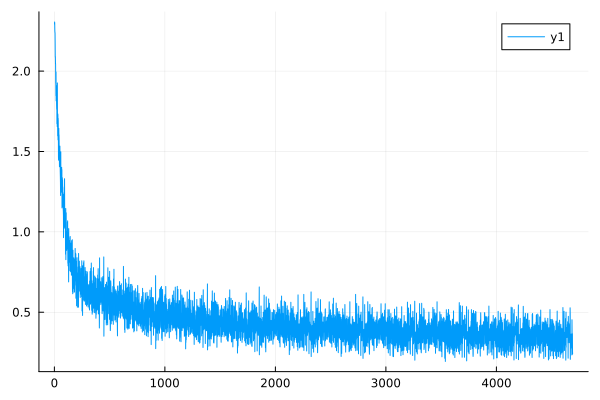

In [24]:
plot(losses)

In [25]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [26]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [27]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.1052

In [28]:
test(model, test_loader, pst, stt)

0.846

# Test Phasor network

In [16]:
import .PhasorNetworks: default_bias

In [17]:
p_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => 128, soft_angle),
            PhasorDense(128 => 10, soft_angle),
            Codebook(10 => 10),
            )

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#37),
    layer_3 = WrappedFunction(#38),
    layer_4 = WrappedFunction(#39),
    layer_5 = PhasorConv(
        layer = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),            # 6 parameters
    ),
    layer_6 = PhasorConv(
        layer = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),            # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        layer = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_9 = PhasorDense(
        layer = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),                # 20 parameters
    ),
    layer_10 = Codebook(10 => 10),                # 100 parameters
)      

In [18]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.009854739 0.0038908052 … 0.027410084 -0.042598046; -0.070673175 0.104087085 … 0.049341556 0.08563622; … ; -0.06473391 0.011930782 … -0.06712644 -0.09788201; 0.06555001 0.02655389 … 0.032844663 -0.06681369;;;; 0.07751807 -0.08933787 … -0.077698514 0.026187355; -0.022558916 -0.016725788 … -0.05284896 0.02503194; … ; 0.10457837 0.051915325 … -0.09805432 -0.019708611; 0.0033002049 0.04073822 … -0.05697163 -0.09414006;;;; -0.089306 0.04426323 … -0.03757296 0.091783725; -0.095490396 -0.09812156 … 0.10808913 0.018936118; … ; 0.026458163 0.03929309 … -0.07876754 0.07608826; -0.027097194 0.09594075 … 0.097982176 -0.03557449],), bias = (bias_real = Float32[1.0;;; 1.0;;; 1.0], 

In [19]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[0.088171795 -0.24406707 … -0.044202536 -0.1815627; -0.21342781 -0.013822916 … -0.18097298 -0.075784504; … ; 0.06490436 0.17413552 … 0.10741017 0.16580167; -0.062100332 0.015209037 … -0.1927121 0.00830968], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = (dense = NamedTuple(), bias = NamedTuple()), layer_9 = (dense = NamedTuple(), bias = NamedTuple()), layer_10 = NamedTuple()))

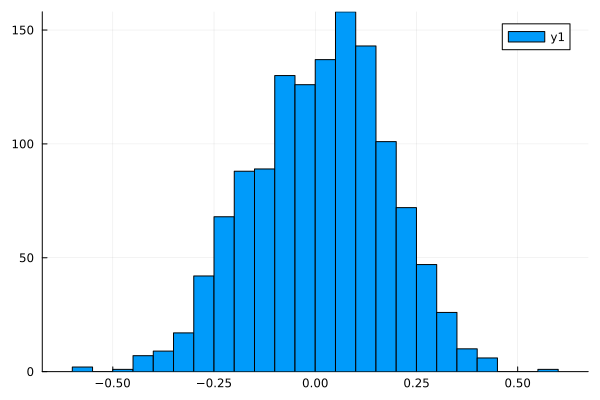

In [20]:
histogram(cdev(vec(yp0)))

In [31]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = codebook_loss(y_pred, y_onehot, dims=1) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [32]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

2.3311656f0

In [33]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CPU


(Any[2.3311656f0, 2.302294f0, 2.3048098f0, 2.3084383f0, 2.2991014f0, 2.329592f0, 2.2929227f0, 2.2791154f0, 2.2503674f0, 2.2608283f0  …  1.5634063f0, 1.5835485f0, 1.5672208f0, 1.5758061f0, 1.5817084f0, 1.5511874f0, 1.5545253f0, 1.5772386f0, 1.5523833f0, 1.5567966f0], (layer_1 = (bias = Float32[-0.08831535 -0.021102676 … -0.17200248 0.014732565; -0.083807744 0.15667953 … -0.13133146 -0.097755626; … ; 0.06993915 0.20398636 … -0.056720395 -0.026675345; -0.06671579 0.122395806 … 0.24938169 -0.112856;;;], scale = Float32[1.0947098 1.0233601 … 1.1672796 0.9816912; 1.0879649 0.8435529 … 1.1425343 1.1141877; … ; 0.9292768 0.7950983 … 1.0923626 1.0540782; 1.0681962 0.87824357 … 0.74171114 1.1160789;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.00944418 0.038195826 … -0.11473333 -0.14613956; -0.12194702 0.1064114 … -0.06441507 -0.0116574215; … ; -0.12501866 -0.026238255 … -0.0027713533 -0.009310834; 0.011637758 -0.02734264 … 0

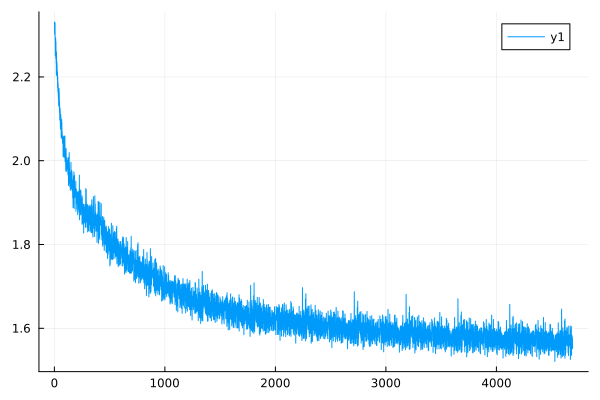

In [34]:
#plot(losses)
plot(losses_f)

In [39]:
yp1, _ = p_model(x0 |> gdev, ps_train_f, st_train_f) 

(Float32[-0.43983126 0.8787732 … -0.2052941 0.21981755; -0.05588026 -0.3796353 … -0.079945125 -0.20205192; … ; -0.1350811 -0.27619547 … -0.21339044 0.30145445; 0.9759186 -0.17526537 … 0.3687271 -0.13530904], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = NamedTuple(), bias = NamedTuple()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = (dense = NamedTuple(), bias = NamedTuple()), layer_9 = (dense = NamedTuple(), bias = NamedTuple()), layer_10 = NamedTuple()))

In [40]:
size(yp1)

(10, 128)

In [42]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_codebook(cdev(y_pred), dims=1)
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [43]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.7187

# Test spiking behavior

In [41]:
spk_model = Chain(LayerNorm((28, 28)),
            x -> reshape(x, (28, 28, 1, :)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorConv((16, 16), 1 => 3, soft_angle),
            PhasorConv((8, 8), 3 => 1, soft_angle),
            FlattenLayer(),
            PhasorDense(36 => 128, soft_angle),
            PhasorDense(128 => 10, soft_angle),
            )
            

Chain(
    layer_1 = LayerNorm((28, 28), affine=true, dims=Colon()),  # 1_568 parameters
    layer_2 = WrappedFunction(#39),
    layer_3 = WrappedFunction(#40),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorConv(
        layer = Conv((16, 16), 1 => 3, use_bias=false),  # 768 parameters
        bias = ComplexBias((1, 1, 3)),            # 6 parameters
    ),
    layer_6 = PhasorConv(
        layer = Conv((8, 8), 3 => 1, use_bias=false),  # 192 parameters
        bias = ComplexBias((1, 1, 1)),            # 2 parameters
    ),
    layer_7 = FlattenLayer{Nothing}(nothing),
    layer_8 = PhasorDense(
        layer = Dense(36 => 128, use_bias=false),  # 4_608 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_9 = PhasorDense(
        layer = Dense(128 => 10, use_bias=false),  # 1_280 parameters
        bias = ComplexBias((10,)),   

In [42]:
spk_args.solver_args[:dt]

0.01f0

In [43]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.05766496 0.08910143 … 0.047003277 0.0139898565; -0.080027506 -0.04998978 … -0.09244675 0.09419803; … ; -0.09271453 0.103725314 … 0.07675693 -0.10073913; 0.07371285 0.016778285 … -0.036770504 -0.014800303;;;; -0.07617716 0.10725441 … -0.038832158 0.043657646; -0.075810574 -0.081823386 … -0.09406755 -0.014487646; … ; -0.049020294 -0.08773717 … -0.045558248 -0.10323291; 0.025260031 0.032799315 … -0.073075496 -0.033021227;;;; -0.094845764 0.051448394 … 0.10673966 -0.077223696; -0.09599363 -0.05307753 … 0.025485748 0.08687767; … ; 0.10436498 -0.036838576 … -0.05724099 -0.03211344; -0.013560799 0.086780466 … -0.043444715 -0.008204564],), bias = (bias_real = Float32[1.0;;; 

In [44]:
typeof(x0)

Array{Float32, 3}

In [45]:
ps0t.layer_5.layer

(weight = Float32[-0.05766496 0.08910143 … 0.047003277 0.0139898565; -0.080027506 -0.04998978 … -0.09244675 0.09419803; … ; -0.09271453 0.103725314 … 0.07675693 -0.10073913; 0.07371285 0.016778285 … -0.036770504 -0.014800303;;;; -0.07617716 0.10725441 … -0.038832158 0.043657646; -0.075810574 -0.081823386 … -0.09406755 -0.014487646; … ; -0.049020294 -0.08773717 … -0.045558248 -0.10323291; 0.025260031 0.032799315 … -0.073075496 -0.033021227;;;; -0.094845764 0.051448394 … 0.10673966 -0.077223696; -0.09599363 -0.05307753 … 0.025485748 0.08687767; … ; 0.10436498 -0.036838576 … -0.05724099 -0.03211344; -0.013560799 0.086780466 … -0.043444715 -0.008204564],)

In [46]:
ps0t.layer_5.bias

(bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag = Float32[0.0;;; 0.0;;; 0.0])

In [47]:
size(x0)

(28, 28, 128)

In [48]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039  …  21.005032, 21.490557, 21.502773, 21.00009, 21.513708, 21.25359, 21.504688, 21.009766, 21.005306, 21.997334], (10, 128), 1280, 1.0f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(), layer_2 = N

In [49]:
ys0.train.shape

(10, 128)

In [58]:
train_to_phase(ys0) |> size

(20, 10, 128)

In [50]:
ys0.train

SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(1, 128), CartesianIndex(2, 128), CartesianIndex(3, 128), CartesianIndex(4, 128), CartesianIndex(5, 128), CartesianIndex(6, 128), CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280], Float32[2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039, 2.500039  …  21.005032, 21.490557, 21.502773, 21.00009, 21.513708, 21.25359, 21.504688, 21.009766, 21.005306, 21.997334], (10, 128), 1280, 1.0f0)

In [51]:
ys0.t_span

(0.0f0, 20.0f0)

In [81]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    acc = []
    n_phases = []
    num = 0

    n_batches = length(data_loader)

    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
            y = gdev(1.0f0 .* onehotbatch(y, 0:9))
        end
        
        spk_output, _ = model(x, ps, st)
        ŷ = train_to_phase(spk_output)
        
        push!(acc, sum.(accuracy_quadrature(ŷ, y))) ## Decode the output of the model
        num += size(x)[end]
    end

    #acc = sum(reshape(acc, :, n_batches), dims=2) ./ num 
    return acc, num
end

fmnist_spiking_accuracy (generic function with 1 method)

In [82]:
spk_a, spk_n = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)

(Any[[12, 12, 15, 56, 90, 103, 107, 107, 108, 109, 108, 108, 108, 109, 109, 107, 107, 107, 107, 16], [9, 9, 13, 46, 89, 108, 109, 110, 111, 112, 112, 113, 113, 112, 112, 112, 111, 112, 112, 17], [9, 9, 16, 46, 87, 108, 109, 110, 111, 111, 111, 112, 112, 112, 113, 112, 111, 111, 111, 14], [10, 10, 15, 57, 86, 101, 103, 102, 106, 106, 106, 106, 107, 107, 107, 107, 107, 108, 108, 16], [10, 10, 15, 48, 82, 102, 103, 104, 103, 104, 105, 104, 104, 104, 104, 104, 104, 104, 104, 19], [11, 11, 18, 63, 94, 100, 104, 104, 104, 103, 103, 102, 102, 102, 104, 104, 104, 104, 103, 17], [14, 14, 12, 44, 85, 105, 111, 110, 111, 111, 113, 114, 114, 114, 115, 115, 115, 115, 115, 10], [16, 16, 15, 50, 82, 102, 102, 104, 105, 104, 104, 104, 105, 104, 103, 104, 104, 104, 104, 20], [16, 16, 14, 52, 91, 102, 103, 105, 107, 108, 108, 107, 107, 108, 108, 108, 108, 109, 108, 23], [13, 13, 17, 48, 87, 98, 99, 99, 100, 102, 102, 102, 103, 103, 102, 101, 100, 99, 100, 21]  …  [7, 7, 17, 41, 78, 94, 101, 100, 100, 10

In [86]:
l2 = [x[1:20] for x in spk_a] |> stack;

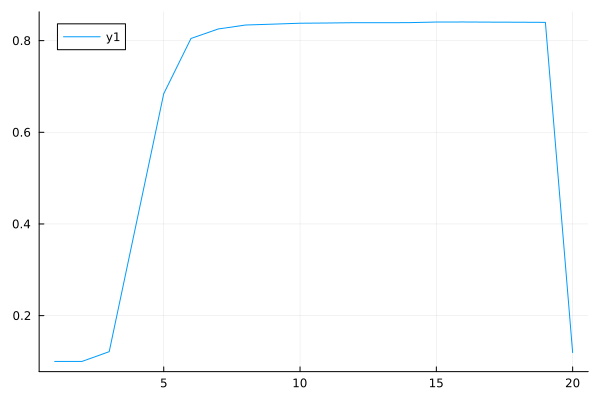

In [91]:
plot(sum(l2, dims=2) ./ spk_n)